[array([[ 39.85184, 116.69171],
       [ 39.85184, 116.6917 ],
       [ 39.85184, 116.6917 ],
       [ 39.85146, 116.69168],
       [ 39.85165, 116.69172],
       [ 39.85165, 116.69176],
       [ 39.85163, 116.69168],
       [ 39.85159, 116.69166],
       [ 39.85186, 116.69164],
       [ 39.85196, 116.69167],
       [ 39.85167, 116.69167],
       [ 39.85183, 116.69176],
       [ 39.85174, 116.69173],
       [ 39.85179, 116.69172],
       [ 39.85176, 116.69171],
       [ 39.85176, 116.6917 ],
       [ 39.85165, 116.69164],
       [ 39.85181, 116.69155],
       [ 39.8518 , 116.69158],
       [ 39.85141, 116.69156],
       [ 39.85155, 116.69161],
       [ 39.85161, 116.69156],
       [ 39.85156, 116.6916 ],
       [ 39.85176, 116.6918 ],
       [ 39.85177, 116.69179],
       [ 39.85176, 116.69176],
       [ 39.85175, 116.69177],
       [ 39.85211, 116.69157],
       [ 39.85157, 116.69162],
       [ 39.85158, 116.69162],
       [ 39.8516 , 116.69161],
       [ 39.85178, 116.69138],
       

Đánh giá K: 100%|██████████| 20/20 [00:00<00:00, 670.12it/s]

0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737
0.6519285874768737


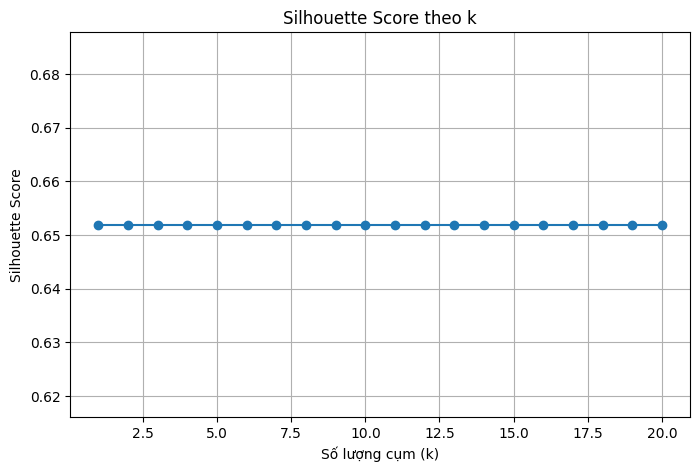

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from tslearn.metrics import cdist_dtw
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import random
from sklearn_extra.cluster import KMedoids
import similaritymeasures

from sklearn.cluster import DBSCAN

random.seed(42)
np.random.seed(42)

def read_and_prepare_trajectories(csv_file):

    df = pd.read_csv(csv_file)

    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

    df.sort_values(by=['TaxiID', 'TimeStamp'], inplace=True)
 
    trajectories = []
    for taxi_id, group in df.groupby('TaxiID'):
        traj = group[['Latitude', 'Longitude']].to_numpy()
        trajectories.append(traj)
    print(trajectories)
    print(len(trajectories), "trajectories")
    return trajectories

def point_to_line_distance(point, start, end):
    x0, y0 = point
    x1, y1 = start
    x2, y2 = end
    num = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    den = math.hypot(y2 - y1, x2 - x1)
    if den == 0:
        return math.hypot(x0 - x1, y0 - y1)
    return num / den

def rdp_with_index(points, indices, epsilon):
    """rdp with returned point indices
    """
    dmax, index = 0.0, 0
    for i in range(1, len(points) - 1):
        d = point_to_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            dmax, index = d, i
    if dmax >= epsilon:
        first_points, first_indices = rdp_with_index(points[:index+1], indices[:index+1], epsilon)
        second_points, second_indices = rdp_with_index(points[index:], indices[index:], epsilon)
        results = first_points[:-1] + second_points
        results_indices = first_indices[:-1] + second_indices
    else:
        results, results_indices = [points[0], points[-1]], [indices[0], indices[-1]]
    return results, results_indices

def simplify_trajectories(traj_data, epsilon=0.0005):
    simplified_trajs = []
    simplified_indices = []

    for traj in traj_data:
        indices = list(range(len(traj)))
        simp_points, simp_indices = rdp_with_index(traj, indices, epsilon)
        simplified_trajs.append(np.array(simp_points))
        simplified_indices.append(simp_indices)
    
    return simplified_trajs, simplified_indices

def cluster_with_kmedoids_dtw(trajectories, k_range=(3, 20)):
    np.random.seed(42)
    trajectories, simlified_indices = simplify_trajectories(trajectories, epsilon=0.00006)
    # Padding về cùng độ dài
    max_len = max(len(traj) for traj in trajectories)
    padded_trajectories = np.array([
        np.pad(traj, ((0, max_len - len(traj)), (0, 0)), mode='edge') 
        for traj in trajectories
    ])
    n = len(padded_trajectories)
    if n < 2:
        return np.array([])
    
    dist_matrix = np.zeros((n, n))
    max_len = max(len(traj) for traj in padded_trajectories)
    padded_trajectories = np.array([
        np.pad(traj, ((0, max_len - len(traj)), (0, 0)), mode='edge') 
        for traj in padded_trajectories
    ])

    # for i in range(n - 1):
    #     p = padded_trajectories[i]
    #     for j in range(i + 1, n):
    #         q = padded_trajectories[j]
    #         dist_matrix[i, j] = similaritymeasures.frechet_dist(p, q)
    #         dist_matrix[j, i] = dist_matrix[i, j] 
    
    print("Tính toán ma trận khoảng cách...")
    # dist_matrix = cdist_dtw(padded_trajectories)
    # np.save('/home/minsun/Documents/Implementing Project/CS313.P23.G9/matrix_weights/b_frechet_dist_matrix.npy', dist_matrix)
    print('Done')
    dist_matrix = np.load('/home/minsun/Documents/Implementing Project/CS313.P23.G9/matrix_weights/b_frechet_dist_matrix.npy')
    silhouette_scores = []
    tested_k = []
    
    for k in tqdm(range(k_range[0], k_range[1] + 1), desc="Đánh giá K"):
        if k >= len(trajectories):  
            break
        try:
            # model = KMedoids(n_clusters=k, metric='precomputed', random_state=42)
            model = DBSCAN(eps=0.4, metric='precomputed', min_samples=k)
            # model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')

            labels = model.fit_predict(dist_matrix)
            score = silhouette_score(dist_matrix, labels, metric='precomputed')
            print(score)
            silhouette_scores.append(score)
            tested_k.append(k)
        except Exception as e:
            print(f"Lỗi với k={k}: {e}")

    plt.figure(figsize=(8, 5))
    plt.plot(tested_k, silhouette_scores, marker='o')
    plt.xlabel("Số lượng cụm (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score theo k")
    plt.grid(True)
    plt.show()


def main_dtw_kmedoids():
    # csv_file = '/home/minsun/Documents/Implementing Project/CS313.P23.G9/datasets/taxi_data_subset.csv'
    csv_file = "/home/minsun/Documents/Implementing Project/CS313.P23.G9/filtered_taxi_data.csv"
    trajectories = read_and_prepare_trajectories(csv_file)
    print(len(trajectories), "trajectories")
    cluster_with_kmedoids_dtw(trajectories, k_range=(1, 20))

if __name__ == '__main__':
    main_dtw_kmedoids()
